In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

from nltk.tokenize import word_tokenize


# Filtering unreliable labelers
This notebook is set to finilize Shaul's and Hernan's exploration regarding filtering unreliable labelers:<br>
1. labelers whos response time is extremly high<br>
2. labelers who's std<1 & mean on-random-random labels <0 <br>
3. labelers who has more than 50 % disagreement with the rest <br>

In [4]:
df = pd.read_csv("data/combined/combined_dataset.csv").drop(['Unnamed: 0'], axis = 1)


# 1. removing time outliers
we will start by removing all annotation that take longer than 5 minutes (95 th percentile) 

count    39660.000000
mean        86.010867
std        427.060791
min          1.000000
25%          7.000000
50%         12.000000
75%         28.000000
90%        169.000000
95%        336.000000
max      14079.000000
Name: total_seconds, dtype: float64

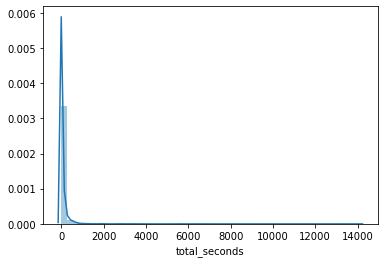

In [5]:
sns.distplot(df.total_seconds)
df.total_seconds.describe(percentiles = [.25,.5,.75,.9,.95])

In [6]:
filtered = df[df.total_seconds<300]

# 2 removing labelers whos std is too low mean non-random - random difference is too high 

In [7]:
labelers = df[df.random==0].groupby(['annotator'])['label'].agg(['size','mean','std','min','max'])
labelers = labelers[labelers['size']>1]
#df = df[df.annotator.apply(lambda x:x in set(labelers.index))]

labelers_rand = df[df.random==1].groupby(['annotator'])['label'].agg(['size','mean','std','min','max'])
labelers_rand = labelers_rand[labelers_rand['size']>1]
labelers = labelers.join(labelers_rand, rsuffix = '_rand')
labelers['mean_random_gap'] = labelers['mean']-labelers['mean_rand']
labelers['std_ratio'] = labelers['std']/labelers['std_rand']

total_std = df.groupby('annotator')['label'].std()
total_std.name = 'total_std'
labelers = labelers.join(total_std)

df=df.reset_index().drop('index',axis = 1)

In [8]:
suspicoius = labelers[(labelers.total_std<1) & (labelers.mean_random_gap < 0)]

In [9]:
filtered = filtered[filtered.annotator.apply(lambda x: x not in suspicoius.index)]

# 3. removing annotators that disagree with the other 2 annotators more than 50 % of the time

In [10]:
df_uniquelabels = df.groupby("pair_id")["reduced_label"].nunique()
pairs_twoagree = list(df_uniquelabels[(df.groupby("pair_id")["reduced_label"].nunique() == 2).values].index)
df_twoagree = df[df["pair_id"].isin(pairs_twoagree)]

df_id_reducedlabel = df_twoagree.groupby("pair_id")['reduced_label'].median()
df_twoagree['generally_accepted_label']  = df_id_reducedlabel.values.repeat(3)
df_twoagree[df_twoagree.reduced_label != df_twoagree.generally_accepted_label].groupby('annotator').size()

annotator
A103ZXTULBGA3J     1
A10DMENL2H243H     1
A110SC5K5Y3IHS     3
A11YCM5MVQ35YY    10
A123PBQDU71I5O     6
                  ..
AYTMDUH1UGG17      1
AYYSG3O9FNU15      6
AZFMVBE87KJRP      1
AZYMR3317SUFN     23
AZZWHDNPNOKSG      7
Length: 404, dtype: int64

In [11]:
df_unpopularopinion = df_twoagree[df_twoagree.reduced_label != df_twoagree.generally_accepted_label].groupby('annotator').size().reset_index()
df_unpopularopinion.columns = ['annotator','unpopular_opinion']

df_allopinions = df[df['annotator'].isin(list(df_unpopularopinion.annotator))].groupby('annotator').size().reset_index()
df_allopinions.columns = ['annotator','all_opinion']

df_opinion_all_unpop = df_allopinions.merge(df_unpopularopinion,on="annotator")

In [12]:
uncompromizing = df_opinion_all_unpop[((df_opinion_all_unpop.unpopular_opinion / df_opinion_all_unpop.all_opinion) > 0.5) & (df_opinion_all_unpop.all_opinion > 4)]
filtered = filtered[filtered.annotator.apply(lambda x: x not in uncompromizing.annotator.values)]

In [13]:
filtered.groupby('random').describe().T.join(df.groupby('random').describe().T,rsuffix = '_original')

random                          0             1    0_original    1_original
label         count  15510.000000  15067.000000  20277.000000  19383.000000
              mean       3.459768      1.888498      3.420427      2.111077
              std        1.350794      1.168150      1.292016      1.228716
              min        1.000000      1.000000      1.000000      1.000000
              25%        2.000000      1.000000      3.000000      1.000000
              50%        4.000000      1.000000      4.000000      2.000000
              75%        5.000000      3.000000      5.000000      3.000000
              max        5.000000      5.000000      5.000000      5.000000
total_seconds count  15510.000000  15067.000000  20277.000000  19383.000000
              mean      28.382076     25.301586     95.997436     75.563690
              std       49.073158     45.430733    494.432582    342.389553
              min        1.000000      1.000000      1.000000      1.000000
              25%        7.000000      6.000000      7.000000      7.000000
              50%       11.000000     10.000000     12.000000     11.000000
              75%       21.000000     19.000000     29.000000     26.000000
              max      299.000000    299.000000  13492.000000  14079.000000
reduced_label count  15510.000000  15067.000000  20277.000000  19383.000000
              mean       0.290200     -0.594810      0.269961     -0.471134
              std        0.843511      0.708060      0.827623      0.758932
              min       -1.000000     -1.000000     -1.000000     -1.000000
              25%       -1.000000     -1.000000      0.000000     -1.000000
              50%        1.000000     -1.000000      1.000000     -1.000000
              75%        1.000000      0.000000      1.000000      0.000000
              max        1.000000      1.000000      1.000000      1.000000

In [14]:
num_annot = filtered.annotator.nunique()
tot_annot = df.annotator.nunique()
print(f'after preforming all filtering we are reduced to {num_annot} annotators, comparing to {tot_annot} annotators we started with ({np.round(100*num_annot/tot_annot,2)}%)\nnew dataset contains {filtered.shape[0]} labeled pairs ({np.round(filtered.shape[0]*100/df.shape[0],2)}%) of the {df.shape[0]} in the original dataset')

after preforming all filtering we are reduced to 400 annotators, comparing to 463 annotators we started with (86.39%)
new dataset contains 30577 labeled pairs (77.1%) of the 39660 in the original dataset


In [15]:
filtered.to_csv('data/combined/filtered_combined.csv')